In [48]:
import os
import gnssrefl.gps as g
import gnssrefl.rinex2snr as rnx
import gnssrefl.quickLook_function as quick
import gnssrefl.gnssir as guts
import json
import pandas as pd 
import check_parameters
import requests
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="whitegrid");
import re
from datetime import datetime
import numpy as np
# making sure that env variables are set - if they are then nothing will print to screen
g.check_environ_variables()

%matplotlib inline

In [34]:
# Setting up environment variables
# will check if already set. If not, then create them inside this working directory
try:
  %env 'ORBITS'
except:
    orbits_dir = os.getcwd() + '/orbits'
    %set_env ORBITS $orbits_dir
    pass

try:
  %env 'EXE'
except:
    exe_dir = os.getcwd() + '/exe'
    %set_env EXE $exe_dir
    pass

try:
  %env 'REFL_CODE'
except:
    refl_code_dir = os.getcwd()
    %set_env REFL_CODE $refl_code_dir
    pass

env: ORBITS=/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits
env: EXE=/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/exe
env: REFL_CODE=/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter


### Island Park, Idaho
  
**Station Name:**  p360

**Location:**  Island Park, Idaho

**Archive:**  [UNAVCO](http://www.unavco.org)

**DOI:**  [https://doi.org/10.7283/T5DB7ZR3](https://doi.org/10.7283/T5DB7ZR3)

**Ellipsoidal Coordinates:**

- Latitude:  44.31785

- Longitude: -111.45068

- Height: 1857.861 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/P360)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/P360.sta)

[Station Page at PBO H2O](http://cires1.colorado.edu/portal/index.php?product=snow&station=p360)

[Google Map Link](https://goo.gl/maps/EcTkbHjaSaWp4d8H9)

<img src="https://gnss-reflections.org/static/images/P360.jpg" width="500">

## Data Summary

Station p360 is located to the west of Yellowstone National Park, near the town of Island Park in Idaho.  At an elevation of ~1858 m (6096 ft), winter snowfall can be frequent and heavy.

The site is operated by UNAVCO and has been recording multi-GNSS data since March 2020. Before that time, only
the L2C GPS data are of reliable quality. P360 was part of [PBO H2O](http://cires1.colorado.edu/portal/).

More information on the station can be obtained from the [GNSS-IR Web App](https://gnss-reflections.org/fancy6?example=p360), where p360 is one of the test cases for snow depth. The station is in a flat, grassy plain with no obstacles or changes in topography, so elevation and azimuth masks are not required.  The web app has a tab for [Reflection Zone Mapping](https://gnss-reflections.org/rzones?station=p360&lat=0.0&lon=0.0&height=0.0&msl=off&RH=2&eang=1&azim1=0&azim2=360) where reflection zones for selected elevation angles are plotted.  The Reflection Zone Mapping allows for experimentation with reflector heights, elevation angles, and azimuth masks.

In [3]:
%%html
<iframe src="https://gnss-reflections.org/api?example=p360" width="1000" height="900"></iframe>

## Take a Quick Look at the Data

**Make SNR File**

First you need to make an SNR file. Ordinarily one can only access L2C data at
this site using the 1-sec data. To support gnssrefl users, UNAVCO
has created special RINEX files with L2C SNR data in them at a friendlier sample
rate, 15 sec. Use the special archive:

In [35]:
station = 'p360'
year = 2017
doy = 290

lat = 44.3179
long = -111.4507
height = 1857.865

In [36]:
args = check_parameters.rinex2snr(station,year,doy, translator='hybrid', archive='special')
rnx.run_rinex2snr(**args)

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602900.17.snr66


**quickLook** analyzes the [spectral characteristics](https://www.unavco.org/gitlab/gnss_reflectometry/gnssrefl/-/blob/test/docs/quickLook_desc.md) of the SNR data.

In [37]:
# making a plotting function for the quicklook function
def quicklook_results(args, values):
    freq = {1:'L1', 20: 'L2C'}
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    quadrants = ['NW', 'NE', 'SW', 'SE']
    axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    for i, quadrant in enumerate(quadrants):
        satellites = values[quadrant].keys()
        fail_satellites = values[f'f{quadrant}'].keys()

        for failsat in fail_satellites:
            axes[i].plot(values[f'f{quadrant}'][failsat][0], values[f'f{quadrant}'][failsat][1], color='lightgrey') 
        for sat in satellites:
            axes[i].plot(values[quadrant][sat][0], values[quadrant][sat][1])

    ax[0,0].set_title('Northwest', size=14)
    ax[0,1].set_title('Northeast',size=14)
    ax[1,0].set_title('Southwest', size=14)
    ax[1,1].set_title('Southeast', size=14)

    for ax in axes:
        ax.set_xlabel('reflector height (m)', size=14)
        ax.set_ylabel('volts/volts', size=14)
        ax.grid()
    
    fig.suptitle(f'GNSS Station {args["station"].upper()}, {args["year"]} doy {args["doy"]}, freq {freq[args["f"]]}, elevation angles {args["e1"]}-{args["e2"]} \n', size=16)
    fig.tight_layout()
    plt.show()
    
    
def quicklook_metrics(args, values):
#     fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
    quadrants = ['NW', 'NE', 'SW', 'SE']
    
    # re-organizing the data in a plotting friendly format
    success_data = {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise':[], 'Amplitude': []}
    fail_data =  {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise': [], 'Amplitude': []}
    
    for i, quadrant in enumerate(quadrants):
        for j in values[quadrant].keys():
            success_data['Azimuth'].append(datakeys[quadrant][j][0])
            success_data['Reflector Height'].append(datakeys[quadrant][j][1])
            success_data['Peak to Noise'].append(datakeys[quadrant][j][5])
            success_data['Amplitude'].append(datakeys[quadrant][j][4])
        for k in values[f'f{quadrant}'].keys():
            fail_data['Azimuth'].append(datakeys[f'f{quadrant}'][k][0])
            fail_data['Reflector Height'].append(datakeys[f'f{quadrant}'][k][1])
            fail_data['Peak to Noise'].append(datakeys[f'f{quadrant}'][k][5])
            fail_data['Amplitude'].append(datakeys[f'f{quadrant}'][k][4])

    return pd.DataFrame(success_data), pd.DataFrame(fail_data)   

In [ ]:
# To understand what quicklook returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
# check_parameters.quicklook?

minimum elevation angle (degrees) for this dataset:  0.0703


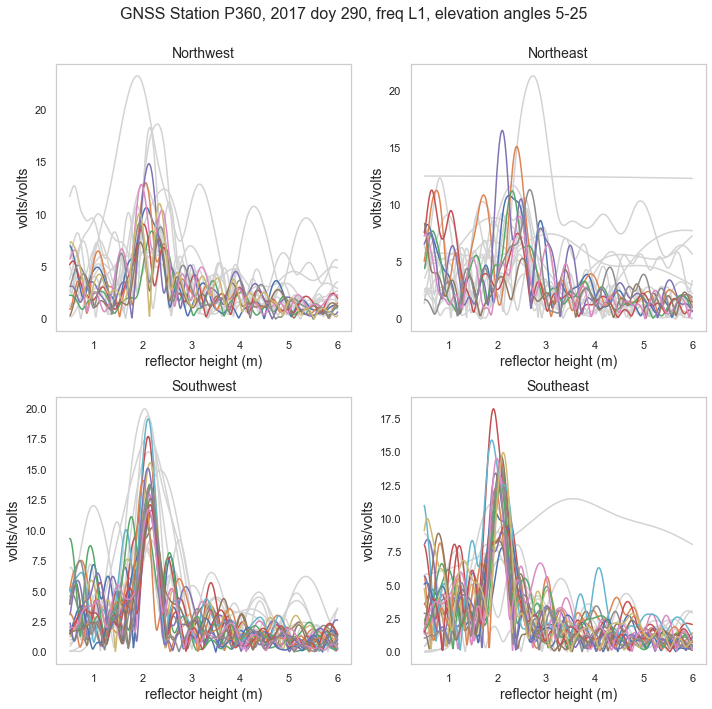

In [38]:
args = check_parameters.quicklook(station, year, doy=doy)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

The default return is for L1. This plot confirms our concerns about the quality of the L1 data.
It also suggests the southern quadrants are preferred to other quadrants.

and for L2C:

minimum elevation angle (degrees) for this dataset:  0.0703


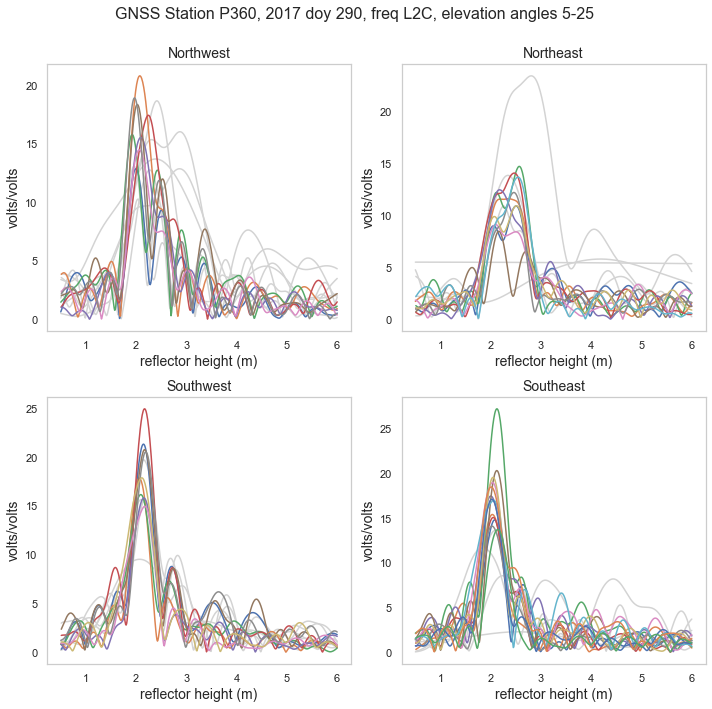

In [39]:
args = check_parameters.quicklook(station, year, doy=doy, f=20)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

These reflector height retrievals are far superior to the L1 data. The southern quadrants give more
consistent retrievals than for the north. This is confirmed in the QC plot show here:

Average reflector height value: 2.2


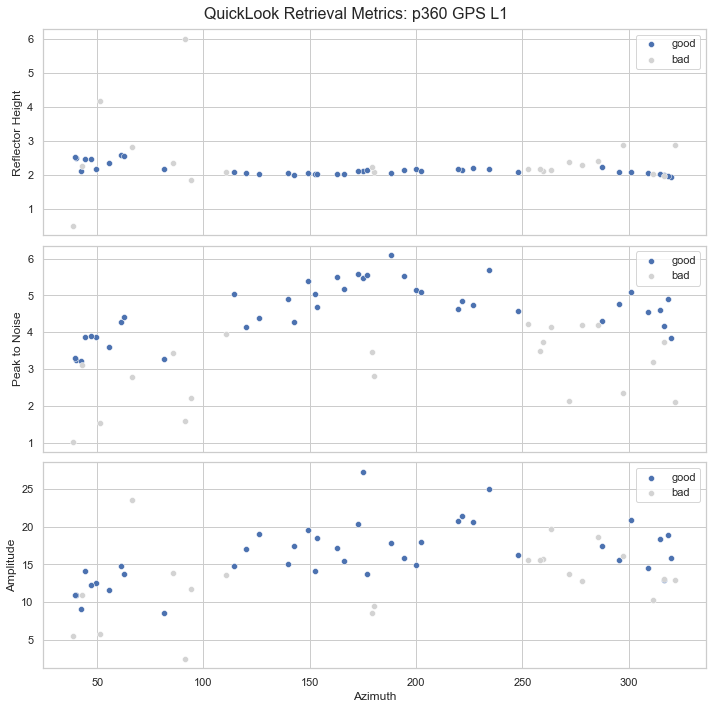

In [40]:
success, fail = quicklook_metrics(args, datakeys)
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook Retrieval Metrics: {args["station"]} GPS L1', size=16)

for i, ax in enumerate(axes):
    g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
    g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')
    
axes[0].legend(loc='upper right')
avg_rh = np.mean(success['Reflector Height'])
# qc_val_peak2noise = round(min(success['Peak to Noise']))
# axes[1].axhline(qc_val_peak2noise, linestyle='--', color='black', label='QC value used')
# qc_val_amp = round(min(success['Amplitude']))
# axes[2].axhline(qc_val_amp, linestyle='--', color='black', label='QC value used')
print(f'Average reflector height value: {avg_rh:.1f}')
# print('QC value for peak to noise:', qc_val_peak2noise)
# print('QC value for amplitude:', qc_val_amp)

plt.tight_layout()
plt.show()

## Analyze the Data

First we will set the analysis paramaters using **make_json_input**. This analysis will use the L2C frequency and
will use QC metrics derived from the previous plot (for peak to noise ratio and amplitude).

In [25]:
# To understand what make_json returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
check_parameters.make_json?

In [23]:
check_parameters.make_json(station, lat, long, height, peak2noise=3.2, ampl=8, l2c=True)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/p360.json


We will hand edit the json file to disallow 0-90 degrees in azimuth.

In [26]:
# This is the json file that was created
json_file = 'input/p360.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    file['azval'] = [90, 180,180,270,270,360]

os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'p360',
 'lat': 44.3179,
 'lon': -111.4507,
 'ht': 1857.865,
 'minH': 0.5,
 'maxH': 6,
 'e1': 5,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 3.2,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [90, 180, 180, 270, 270, 360],
 'freqs': [20],
 'reqAmp': [8],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'p360_lsp.png',
 'delTmax': 75}

We then make SNR files to encompass one water year:

In [28]:
args = check_parameters.rinex2snr(station, year=2017, doy=245, doy_end=365, archive='special', translator='hybrid')
rnx.run_rinex2snr(**args)

Will seek RINEX file  p360  year: 2017  doy: 245  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602450.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 246  translate with  hybrid
found it and move to ORBIT area


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602460.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 247  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602470.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 248  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602480.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 249  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602490.17.snr66
Will seek RINEX file  p360  



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602890.17.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602900.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 291  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602910.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 292  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602920.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 293  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602930.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 294  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602940.17.snr66
Will seek RINEX file  p360  year: 2



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603340.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 335  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603350.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 336  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603360.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 337  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603370.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 338  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603380.17.snr66
Will seek RINEX file  p360  year: 2017  doy: 339  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project

In [29]:
args = check_parameters.rinex2snr(station, year=2018, doy=1, doy_end=145, archive='special', translator='hybrid')
rnx.run_rinex2snr(**args)

Will seek RINEX file  p360  year: 2018  doy: 1  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600010.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 2  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600020.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 3  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600030.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 4  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600040.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 5  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600050.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 6  translate with  hybrid



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600450.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 46  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600460.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 47  translate with  hybrid
found it and move to ORBIT area


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600470.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 48  translate with  hybrid
found it and move to ORBIT area


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600480.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 49  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600490.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 50  translate with  hybrid





SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600900.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 91  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600910.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 92  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600920.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 93  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600930.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 94  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600940.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 95  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601340.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 135  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601350.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 136  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601360.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 137  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601370.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 138  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601380.18.snr66
Will seek RINEX file  p360  year: 2018  doy: 139  translate with  hybrid


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project

Then we run gnssir to calculate the reflector heights for 2017/2018. Because the code
only creates results if the SNR file exists, we can use the year_end and doy_end settings.

In [9]:
year = 2017
doy = 1
doy_end = 366
year_end = 2018
plt=False
args = check_parameters.gnssir(station, year, doy, doy_end=doy_end, year_end=year_end, plt=plt, screenstats=False)
year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

refraction file exists
A station specific refraction output file will be written to  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/p360_refr.txt
The large refraction file should be stored here: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gpt_1wA.pickle
station specific refraction file written
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//001.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600010.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//002.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600020.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//003.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600030.17.snr66
Results are written to: /Users

Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600370.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//038.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600380.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//039.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600390.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//040.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600400.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//041.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600410.17.snr66
Results are

Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600960.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//097.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600970.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//098.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600980.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//099.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3600990.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//100.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3601000.17.snr66
Results are

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//147.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3601470.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//148.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3601480.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//149.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3601490.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//150.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3601500.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//151.txt
Could not read the first SN

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//213.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602130.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//214.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602140.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//215.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602150.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//216.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602160.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//217.txt
Could not read the first SN

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//251.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602510.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//252.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602520.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//253.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602530.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//254.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602540.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//255.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//290.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602900.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//291.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602910.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//292.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602920.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//293.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3602930.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//294.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//329.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603290.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//330.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603300.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//331.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603310.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//332.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/snr/p360/p3603320.17.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//333.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//002.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600020.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//003.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600030.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//004.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600040.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//005.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600050.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//006.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//041.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600410.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//042.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600420.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//043.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600430.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//044.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600440.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//045.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//080.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600800.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//081.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600810.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//082.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600820.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//083.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3600830.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//084.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//119.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601190.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//120.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601200.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//121.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601210.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//122.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3601220.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//123.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3602320.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//233.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3602330.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//234.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3602340.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//235.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3602350.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//236.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3602360.18.snr66
Results are

Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3603320.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//333.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3603330.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//334.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3603340.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//335.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3603350.18.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//336.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/snr/p360/p3603360.18.snr66
Results are

## Derive Snow Accumulation from Reflector Heights

Use the daily_avg utility with a relatively low number of required satellite tracks (12) 
and 0.25 meter median filter to remove large outliers:


In [10]:
check_parameters.daily_avg(station, medfilter=.25, ReqTracks=12, plt2screen=False, txtfile='p360-dailyavg.txt')


all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/p360_allRH.txt
Number of files in  2017 121
not enough retrievals on  2017 12 26 2
not enough retrievals on  2017 12 28 1
not enough retrievals on  2017 12 29 6
not enough retrievals on  2017 12 24 10
not enough retrievals on  2017 12 25 6
not enough retrievals on  2017 12 18 1
not enough retrievals on  2017 12 19 1


/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/check_parameters.py:431: UserWarning: loadtxt: Empty input file: "/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//361.txt"
  a = np.loadtxt(fname, skiprows=3, comments='%').T
/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/check_parameters.py:431: UserWarning: loadtxt: Empty input file: "/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2017/results/p360//351.txt"
  a = np.loadtxt(fname, skiprows=3, comments='%').T


Number of files in  2018 135
not enough retrievals on  2018 3 7 5
not enough retrievals on  2018 3 8 11
not enough retrievals on  2018 1 17 11
not enough retrievals on  2018 1 16 5
not enough retrievals on  2018 2 8 12
not enough retrievals on  2018 2 5 7
not enough retrievals on  2018 2 4 11
not enough retrievals on  2018 1 21 12
not enough retrievals on  2018 1 20 2
not enough retrievals on  2018 2 3 7
not enough retrievals on  2018 1 30 3
not enough retrievals on  2018 1 24 6
not enough retrievals on  2018 1 25 7
not enough retrievals on  2018 1 31 5
not enough retrievals on  2018 1 19 2
not enough retrievals on  2018 2 2 6
not enough retrievals on  2018 2 1 8
not enough retrievals on  2018 3 9 10
not enough retrievals on  2018 2 25 2
not enough retrievals on  2018 2 26 12


/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/check_parameters.py:431: UserWarning: loadtxt: Empty input file: "/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2018/results/p360//026.txt"
  a = np.loadtxt(fname, skiprows=3, comments='%').T


Daily average RH png file saved as:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/p360_RH.png
Daily average RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/p360-dailyavg.txt


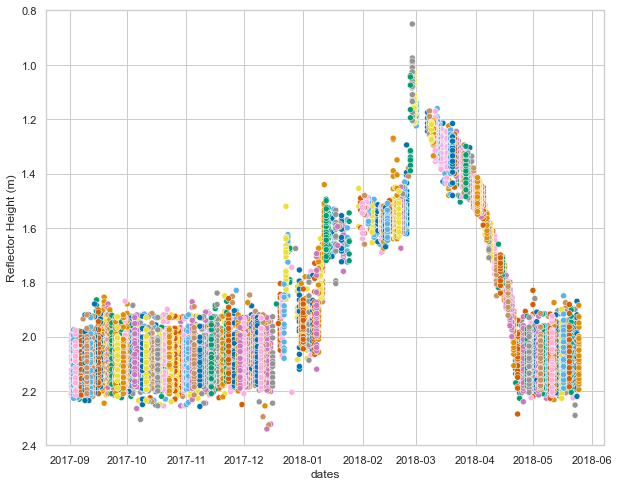

In [45]:
import matplotlib.pyplot as plt

def read_allRH_file(filepath, regex):
    data = {'dates': [], 'rh': []}
    #read daily average reflector heights
    with open(f'{refl_code_dir}{filepath}', 'r') as myfile:
        file = myfile.read()
        matches = re.finditer(regex, file, flags=re.MULTILINE)

        for match in matches:
            ydoy = f'{int(match.group("year"))}-{int(match.group("doy"))}'
            date = datetime.strptime(ydoy, '%Y-%j').date()
            data['dates'].append(date)
            data['rh'].append(float(match.group('rh')))
            
    return data

regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}_allRH.txt'
data = read_allRH_file(filepath, regex)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(10,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim(2.4, .8)
g.set_ylabel('Reflector Height (m)');

This plot makes it clear that there are data outages at p360, particular in the winter months.
This is due to the way the site was built. Power was provided by solar panels and batteries. When
snow covered the solar panels (see the photograph above), the site would soon lose power when
the batteries ran down. When the snow on the panels melted, the site would track again.
This next plot shows the number of reflector heights each day. While they are consistent
in the fall and later spring, there is significant variation in December, January, and February.

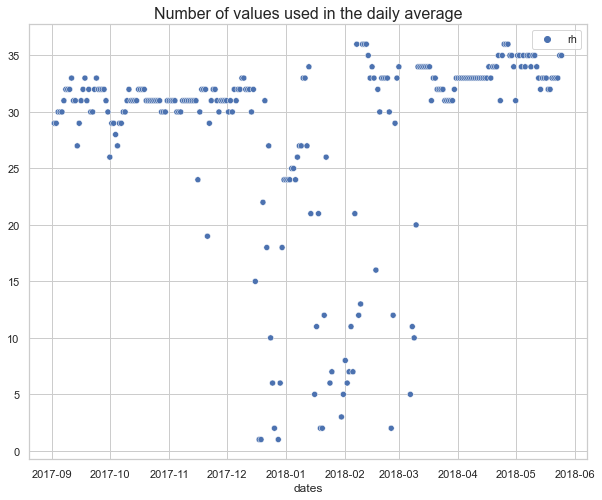

In [46]:
plt.figure(figsize=(10,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

The variation in retrievals in the winter is due to poor data retrieval in those winter months.
This next plot shows the number of total observations in the RINEX file each day. You can see the
correlation between the number of tracks available for the daily average and the number of
observations in the file. For sites with more reliable power, there will not be
data outages during the winter.

Finally, the daily average RH for the water year:

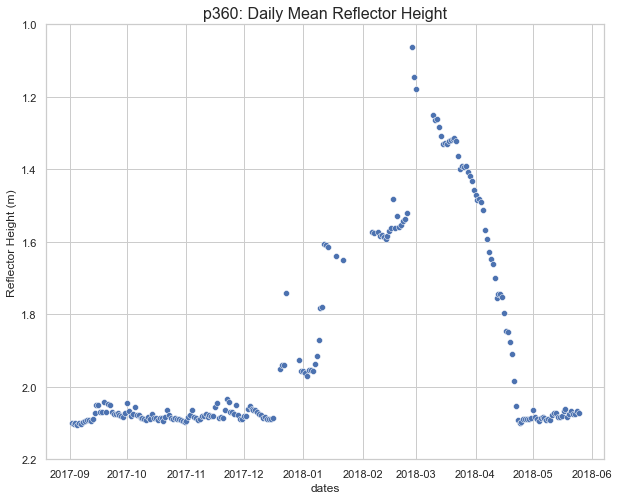

In [47]:
regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}-dailyavg.txt'
data = read_allRH_file(filepath, regex)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

plt.figure(figsize=(10,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(2.2,1)
g.set_ylabel('Reflector Height (m)')
g.set_title(f'{station}: Daily Mean Reflector Height', size=16);